In [1]:
%%capture
!pip install -q datasets
!pip install -q transformers
!pip install -q emoji
!pip install -q vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git
!pip install wandb

In [2]:
%%capture
!wget https://github.com/Savoxism/ABSA-Vietnamese/archive/refs/heads/main.zip -O ABSA-Vietnamese.zip

In [3]:
!unzip ABSA-Vietnamese.zip -d /kaggle/working/
!ls /kaggle/working/ABSA-Vietnamese-main
%cd /kaggle/working/ABSA-Vietnamese-main

Archive:  ABSA-Vietnamese.zip
3a0b640f2de638a35fdcbb5855ade05ba82cb989
   creating: /kaggle/working/ABSA-Vietnamese-main/
  inflating: /kaggle/working/ABSA-Vietnamese-main/.gitattributes  
  inflating: /kaggle/working/ABSA-Vietnamese-main/.gitignore  
  inflating: /kaggle/working/ABSA-Vietnamese-main/LICENSE  
  inflating: /kaggle/working/ABSA-Vietnamese-main/README.md  
   creating: /kaggle/working/ABSA-Vietnamese-main/VnCoreNLP/
  inflating: /kaggle/working/ABSA-Vietnamese-main/VnCoreNLP/VnCoreNLP-1.1.1.jar  
   creating: /kaggle/working/ABSA-Vietnamese-main/dataset/
  inflating: /kaggle/working/ABSA-Vietnamese-main/dataset/1-VLSP2018-SA-Hotel-train.csv  
  inflating: /kaggle/working/ABSA-Vietnamese-main/dataset/2-VLSP2018-SA-Hotel-dev.csv  
  inflating: /kaggle/working/ABSA-Vietnamese-main/dataset/3-VLSP2018-SA-Hotel-test.csv  
  inflating: /kaggle/working/ABSA-Vietnamese-main/eda.ipynb  
  inflating: /kaggle/working/ABSA-Vietnamese-main/finetuning.ipynb  
  inflating: /kaggle/worki

In [4]:
from nltk import flatten
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from vncorenlp import VnCoreNLP

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

from huggingface_hub import login
import wandb
from transformers import AutoTokenizer, AutoModel, AutoConfig, Trainer, TrainingArguments

from preprocess import (
    remove_HTML, 
    convert_unicode, 
    standardize_sentence_typing, 
    normalize_acronym, 
    remove_unnecessary_characters,
)

In [5]:
ANNOTATOR_PATH = "/kaggle/working/VnCoreNLP/VnCoreNLP-1.1.1.jar"  # Change to correct path

if not os.path.exists(ANNOTATOR_PATH):
    raise FileNotFoundError(f"VnCoreNLP JAR file not found at {ANNOTATOR_PATH}")

annotator = VnCoreNLP(ANNOTATOR_PATH)

def word_segmentation(text):
    words = annotator.tokenize(text)
    return ' '.join(word for word in flatten(words))

def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text) 
    text = standardize_sentence_typing(text)
    text = normalize_acronym(text)
    text = word_segmentation(text) 
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

In [6]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Please enable GPU in Kaggle settings.")

GPU is available!
Device: Tesla P100-PCIE-16GB


In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_AUTH_TOKEN")
login(token=hf_token)

In [8]:
wb_token = user_secrets.get_secret("wandb_api_key")

wandb.login(key=wb_token)
run = wandb.init(
    project='ABSA-Vietnamese', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: savoxism (savoxism-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/ABSA-Vietnamese-main/wandb/run-20250209_144118-kqvqgb23
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eternal-firebrand-17
wandb: ⭐️ View project at https://wandb.ai/savoxism-hanoi-university-of-science-and-technology/ABSA-Vietnamese
wandb: 🚀 View run at https://wandb.ai/savoxism-hanoi-university-of-science-and-technology/ABSA-Vietnamese/

# EDA

In [9]:
TRAIN_PATH = "/kaggle/input/vlsp2018-hotel/1-VLSP2018-SA-Hotel-train.csv"
VAL_PATH = "/kaggle/input/vlsp2018-hotel/2-VLSP2018-SA-Hotel-dev.csv"
TEST_PATH = "/kaggle/input/vlsp2018-hotel/3-VLSP2018-SA-Hotel-test.csv"

In [10]:
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

# Tokenizing

In [11]:
PRETRAINED_MODEL = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
print("Max Model Input Size:", tokenizer.model_max_length)
print(tokenizer.model_input_names)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Max Model Input Size: 1000000000000000019884624838656
['input_ids', 'token_type_ids', 'attention_mask']


In [12]:
tokenizer

PhobertTokenizer(name_or_path='vinai/phobert-base', vocab_size=64000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	64000: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [13]:
# tokens = tokenizer.encode('Tôi là sinh viên trường đại học Công nghệ thông tin .') 
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .') # When use PhoBERT
print('Encode:', tokens)
print('Decode:', tokenizer.decode(tokens))

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2]
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin . </s>


In [14]:
label_keys = [
    key for key in raw_datasets['train'].column_names  
    if key not in ["Review", "input_ids", "token_type_ids", "attention_mask"]
]

In [15]:
label_keys

['FACILITIES#CLEANLINESS',
 'FACILITIES#COMFORT',
 'FACILITIES#DESIGN&FEATURES',
 'FACILITIES#GENERAL',
 'FACILITIES#MISCELLANEOUS',
 'FACILITIES#PRICES',
 'FACILITIES#QUALITY',
 'FOOD&DRINKS#MISCELLANEOUS',
 'FOOD&DRINKS#PRICES',
 'FOOD&DRINKS#QUALITY',
 'FOOD&DRINKS#STYLE&OPTIONS',
 'HOTEL#CLEANLINESS',
 'HOTEL#COMFORT',
 'HOTEL#DESIGN&FEATURES',
 'HOTEL#GENERAL',
 'HOTEL#MISCELLANEOUS',
 'HOTEL#PRICES',
 'HOTEL#QUALITY',
 'LOCATION#GENERAL',
 'ROOMS#CLEANLINESS',
 'ROOMS#COMFORT',
 'ROOMS#DESIGN&FEATURES',
 'ROOMS#GENERAL',
 'ROOMS#MISCELLANEOUS',
 'ROOMS#PRICES',
 'ROOMS#QUALITY',
 'ROOM_AMENITIES#CLEANLINESS',
 'ROOM_AMENITIES#COMFORT',
 'ROOM_AMENITIES#DESIGN&FEATURES',
 'ROOM_AMENITIES#GENERAL',
 'ROOM_AMENITIES#MISCELLANEOUS',
 'ROOM_AMENITIES#PRICES',
 'ROOM_AMENITIES#QUALITY',
 'SERVICE#GENERAL']

In [16]:
len(label_keys)

34

In [17]:
def encode_sentiment(sentiment):
    sentiment_map = {
        0: [1, 0, 0, 0],  # None
        1: [0, 1, 0, 0],  # Positive
        2: [0, 0, 1, 0],  # Negative
        3: [0, 0, 0, 1]   # Neutral
    }
    return sentiment_map.get(sentiment, [1, 0, 0, 0])  # Default to "None"

def clean_text(review):
    # print("used")
    return text_preprocess(review) if isinstance(review, str) else ""

In [18]:
example = raw_datasets["train"][2]

In [19]:
example

{'Review': 'Phục vụ, view đẹp, vị trí',
 'FACILITIES#CLEANLINESS': 0,
 'FACILITIES#COMFORT': 0,
 'FACILITIES#DESIGN&FEATURES': 0,
 'FACILITIES#GENERAL': 0,
 'FACILITIES#MISCELLANEOUS': 0,
 'FACILITIES#PRICES': 0,
 'FACILITIES#QUALITY': 0,
 'FOOD&DRINKS#MISCELLANEOUS': 0,
 'FOOD&DRINKS#PRICES': 0,
 'FOOD&DRINKS#QUALITY': 0,
 'FOOD&DRINKS#STYLE&OPTIONS': 0,
 'HOTEL#CLEANLINESS': 0,
 'HOTEL#COMFORT': 0,
 'HOTEL#DESIGN&FEATURES': 0,
 'HOTEL#GENERAL': 1,
 'HOTEL#MISCELLANEOUS': 0,
 'HOTEL#PRICES': 0,
 'HOTEL#QUALITY': 0,
 'LOCATION#GENERAL': 1,
 'ROOMS#CLEANLINESS': 0,
 'ROOMS#COMFORT': 0,
 'ROOMS#DESIGN&FEATURES': 0,
 'ROOMS#GENERAL': 0,
 'ROOMS#MISCELLANEOUS': 0,
 'ROOMS#PRICES': 0,
 'ROOMS#QUALITY': 0,
 'ROOM_AMENITIES#CLEANLINESS': 0,
 'ROOM_AMENITIES#COMFORT': 0,
 'ROOM_AMENITIES#DESIGN&FEATURES': 0,
 'ROOM_AMENITIES#GENERAL': 0,
 'ROOM_AMENITIES#MISCELLANEOUS': 0,
 'ROOM_AMENITIES#PRICES': 0,
 'ROOM_AMENITIES#QUALITY': 0,
 'SERVICE#GENERAL': 1}

In [20]:
# Step 1: Clean text
cleaned_text_result = clean_text(example["Review"])
print("Cleaned Text:", cleaned_text_result)

Cleaned Text: phục_vụ view đẹp vị_trí


In [21]:
def clean_review_text(example):
    example["Review"] = clean_text(example["Review"])
    return example

# Apply the cleaning function to all dataset splits (train, val, test)
cleaned_datasets = raw_datasets.map(clean_review_text, batched=False)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [22]:
cleaned_datasets['train'][0]

{'Review': 'rộng_rãi khách_sạn mới nhưng rất vắng các dịch_vụ chất_lượng chưa cao và thiếu',
 'FACILITIES#CLEANLINESS': 0,
 'FACILITIES#COMFORT': 0,
 'FACILITIES#DESIGN&FEATURES': 0,
 'FACILITIES#GENERAL': 0,
 'FACILITIES#MISCELLANEOUS': 0,
 'FACILITIES#PRICES': 0,
 'FACILITIES#QUALITY': 0,
 'FOOD&DRINKS#MISCELLANEOUS': 0,
 'FOOD&DRINKS#PRICES': 0,
 'FOOD&DRINKS#QUALITY': 0,
 'FOOD&DRINKS#STYLE&OPTIONS': 0,
 'HOTEL#CLEANLINESS': 0,
 'HOTEL#COMFORT': 0,
 'HOTEL#DESIGN&FEATURES': 1,
 'HOTEL#GENERAL': 2,
 'HOTEL#MISCELLANEOUS': 0,
 'HOTEL#PRICES': 0,
 'HOTEL#QUALITY': 0,
 'LOCATION#GENERAL': 0,
 'ROOMS#CLEANLINESS': 0,
 'ROOMS#COMFORT': 0,
 'ROOMS#DESIGN&FEATURES': 0,
 'ROOMS#GENERAL': 0,
 'ROOMS#MISCELLANEOUS': 0,
 'ROOMS#PRICES': 0,
 'ROOMS#QUALITY': 0,
 'ROOM_AMENITIES#CLEANLINESS': 0,
 'ROOM_AMENITIES#COMFORT': 0,
 'ROOM_AMENITIES#DESIGN&FEATURES': 0,
 'ROOM_AMENITIES#GENERAL': 0,
 'ROOM_AMENITIES#MISCELLANEOUS': 0,
 'ROOM_AMENITIES#PRICES': 0,
 'ROOM_AMENITIES#QUALITY': 0,
 'SERVICE#

In [23]:
def tokenize_cleaned_example(example):
    """Tokenizes the cleaned text and ensures all outputs remain as NumPy arrays."""

    # ✅ Tokenize cleaned text
    tokenized_inputs = tokenizer(
        example["Review"],  
        max_length=256, 
        padding="max_length", 
        truncation=True
    )

    # ✅ Convert input fields to NumPy arrays
    tokenized_inputs["input_ids"] = np.array(tokenized_inputs["input_ids"], dtype=np.int64)
    tokenized_inputs["attention_mask"] = np.array(tokenized_inputs["attention_mask"], dtype=np.int64)

    # ✅ Binary aspect labels (1 if aspect exists, 0 otherwise)
    aspect_labels = np.array([1 if example[key] > 0 else 0 for key in label_keys], dtype=np.float32)

    # ✅ One-hot sentiment labels
    sentiment_labels = np.array([encode_sentiment(example.get(key, 0)) for key in label_keys], dtype=np.int64)

    # ✅ Explicitly ensure returned values are still NumPy arrays
    return {
        "input_ids": np.array(tokenized_inputs["input_ids"], dtype=np.int64),
        "attention_mask": np.array(tokenized_inputs["attention_mask"], dtype=np.int64),
        "aspect_labels": np.array(aspect_labels, dtype=np.float32),
        "sentiment_labels": np.array(sentiment_labels, dtype=np.int64)
    }

In [24]:
# Apply tokenization to the cleaned dataset
tokenized_dataset = cleaned_datasets.map(tokenize_cleaned_example, batched=False)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [25]:
sample = tokenized_dataset["train"][0]
print(
    type(sample["sentiment_labels"]), 
    type(sample["aspect_labels"]), 
    type(sample["input_ids"]), 
    type(sample["attention_mask"])
)


<class 'list'> <class 'list'> <class 'list'> <class 'list'>


# Prepare for Training

In [26]:
import torch
import torch.nn.functional as F
def collate_fn(batch):
    """Ensures inputs and labels are converted to PyTorch tensors correctly."""
    
    input_ids = torch.tensor([item["input_ids"] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item["attention_mask"] for item in batch], dtype=torch.long)

    # ✅ Convert aspect_labels to one-hot encoding for binary classification
    aspect_labels = torch.tensor([item["aspect_labels"] for item in batch], dtype=torch.long)
    aspect_labels = F.one_hot(aspect_labels, num_classes=2).float()  # ✅ Now (batch_size, num_aspects, 2)

    sentiment_labels = torch.tensor([item["sentiment_labels"] for item in batch], dtype=torch.int64)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "aspect_labels": aspect_labels,  # ✅ Now has shape (batch_size, num_aspects, 2)
        "sentiment_labels": sentiment_labels
    }



train_loader = DataLoader(
    tokenized_dataset["train"], 
    batch_size=8, 
    collate_fn=collate_fn, 
    shuffle=True
)

eval_loader = DataLoader(
    tokenized_dataset["val"], 
    batch_size=8, 
    collate_fn=collate_fn
)

In [27]:
batch = next(iter(train_loader))

print(type(batch["input_ids"]))  # ✅ Expected: <class 'torch.Tensor'>
print(type(batch["attention_mask"]))  # ✅ Expected: <class 'torch.Tensor'>
print(type(batch["aspect_labels"]))  # ✅ Expected: <class 'torch.Tensor'>
print(type(batch["sentiment_labels"]))  # ✅ Expected: <class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [28]:
for batch in train_loader:
    print("✅ aspect_labels Shape:", batch["aspect_labels"].shape)  
    break

✅ aspect_labels Shape: torch.Size([8, 34, 2])


# Initialize Model

In [29]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class PhoBERTMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_aspects):
        super(PhoBERTMultiTaskModel, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        self.config = AutoConfig.from_pretrained(model_name)  
        self.hidden_size = self.bert.config.hidden_size * 4  # Concatenating last 4 layers

        self.dropout = nn.Dropout(0.2)

        # ✅ Aspect Detection: Binary classification (Aspect Present: 1, Not Present: 0)
        self.aspect_detectors = nn.ModuleList([
            nn.Linear(self.hidden_size, 2) for _ in range(num_aspects)
        ])

        # ✅ Sentiment Classification: 4-class classification (None, Positive, Negative, Neutral)
        self.aspect_classifiers = nn.ModuleList([
            nn.Linear(self.hidden_size, 4) for _ in range(num_aspects)
        ])

    def forward(self, input_ids, attention_mask, aspect_labels=None, sentiment_labels=None, **kwargs):
        """
        Forward function modified to accept aspect_labels and sentiment_labels.
        These labels are ignored during inference but used in training.
        """

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.hidden_states  
        pooled_output = torch.cat([hidden_states[-i][:, 0, :] for i in range(1, 5)], dim=-1)
        pooled_output = self.dropout(pooled_output)

        # ✅ Aspect Detection (Binary Classification)
        aspect_presence = [detector(pooled_output) for detector in self.aspect_detectors]
        aspect_presence = torch.stack(aspect_presence, dim=1)  # (batch_size, num_aspects, 2)

        # ✅ Sentiment Classification (4-class Classification)
        aspect_sentiment = [classifier(pooled_output) for classifier in self.aspect_classifiers]
        aspect_sentiment = torch.stack(aspect_sentiment, dim=1)  # (batch_size, num_aspects, 4)

        return aspect_presence, aspect_sentiment

In [30]:
class PhoBERTTrainer(Trainer):
    step_counter = 0  # ✅ Track steps

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Custom loss function for Multi-Task Aspect-Based Sentiment Analysis."""
        
        if "aspect_labels" not in inputs or "sentiment_labels" not in inputs:
            raise ValueError(f"🚨 Missing required labels. Available keys: {inputs.keys()}")

        aspect_labels = inputs["aspect_labels"]  # ✅ One-hot labels (batch_size, num_aspects, 2)
        sentiment_labels = inputs["sentiment_labels"]  # ✅ One-hot sentiment labels
        
        # ✅ Forward pass (model outputs two things now)
        aspect_preds, sentiment_preds = model(**inputs)

        # ✅ Binary Classification Loss for Aspect Detection
        aspect_loss_fn = nn.BCEWithLogitsLoss()
        aspect_loss = aspect_loss_fn(aspect_preds, aspect_labels)

        # ✅ Convert one-hot to class index for Sentiment Classification
        sentiment_labels = torch.argmax(sentiment_labels, dim=-1)  # Convert one-hot to class index
        sentiment_loss_fn = nn.CrossEntropyLoss()
        sentiment_loss = sentiment_loss_fn(sentiment_preds.view(-1, 4), sentiment_labels.view(-1))

        # ✅ Total Loss
        total_loss = aspect_loss + sentiment_loss

        # 🔹 **Accuracy Calculation**
        with torch.no_grad():
            # Aspect Detection Accuracy (Binary)
            aspect_pred_classes = (torch.sigmoid(aspect_preds) > 0.5).long()  # Convert logits to binary classes
            aspect_accuracy = (aspect_pred_classes == aspect_labels.long()).float().mean().item()

            # Sentiment Classification Accuracy (4-class)
            sentiment_pred_classes = torch.argmax(sentiment_preds, dim=-1)  # Get predicted class index
            sentiment_accuracy = (sentiment_pred_classes == sentiment_labels).float().mean().item()

            # ✅ Print accuracy every 200 steps
            self.step_counter += 1
            if self.step_counter % 200 == 0:
                print(f"🔹 Step {self.step_counter}: Aspect Accuracy: {aspect_accuracy:.4f} | Sentiment Accuracy: {sentiment_accuracy:.4f}")

        return (total_loss, (aspect_preds, sentiment_preds)) if return_outputs else total_loss


# Finetuning

In [31]:
training_args = TrainingArguments(
    output_dir="./phobert_multitask",
    eval_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
    num_train_epochs=25,  # Adjust based on dataset size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    report_to="wandb",
)

In [32]:
model = PhoBERTMultiTaskModel("vinai/phobert-base", len(label_keys))
model.to('cuda')

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

PhoBERTMultiTaskModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [33]:
trainer = PhoBERTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=collate_fn
)

<ipython-input-33-dd3af5ddb826>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PhoBERTTrainer.__init__`. Use `processing_class` instead.
  trainer = PhoBERTTrainer(


In [34]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
200,1.374100
400,0.718200
600,0.648900
800,0.563500
1000,0.496000
1200,0.455700
1400,0.405500
1600,0.368100
1800,0.333500
2000,0.301300


🔹 Step 200: Aspect Accuracy: 0.8824 | Sentiment Accuracy: 0.8824
🔹 Step 400: Aspect Accuracy: 0.8713 | Sentiment Accuracy: 0.8824
🔹 Step 600: Aspect Accuracy: 0.8842 | Sentiment Accuracy: 0.8971
🔹 Step 800: Aspect Accuracy: 0.8658 | Sentiment Accuracy: 0.8529
🔹 Step 1000: Aspect Accuracy: 0.9191 | Sentiment Accuracy: 0.9228
🔹 Step 1200: Aspect Accuracy: 0.8897 | Sentiment Accuracy: 0.9081
🔹 Step 1400: Aspect Accuracy: 0.9688 | Sentiment Accuracy: 0.9669
🔹 Step 1600: Aspect Accuracy: 0.9540 | Sentiment Accuracy: 0.9559
🔹 Step 1800: Aspect Accuracy: 0.9467 | Sentiment Accuracy: 0.9449
🔹 Step 2000: Aspect Accuracy: 0.9577 | Sentiment Accuracy: 0.9522
🔹 Step 2200: Aspect Accuracy: 0.9485 | Sentiment Accuracy: 0.9522
🔹 Step 2400: Aspect Accuracy: 0.9835 | Sentiment Accuracy: 0.9743
🔹 Step 2600: Aspect Accuracy: 0.9669 | Sentiment Accuracy: 0.9632
🔹 Step 2800: Aspect Accuracy: 0.9779 | Sentiment Accuracy: 0.9743
🔹 Step 3000: Aspect Accuracy: 0.9596 | Sentiment Accuracy: 0.9596
🔹 Step 3200: A

TrainOutput(global_step=9375, training_loss=0.18931740366617839, metrics={'train_runtime': 2134.0357, 'train_samples_per_second': 35.145, 'train_steps_per_second': 4.393, 'total_flos': 0.0, 'train_loss': 0.18931740366617839, 'epoch': 25.0})

In [35]:
results = trainer.evaluate()
print(results)

🔹 Step 9400: Aspect Accuracy: 0.9632 | Sentiment Accuracy: 0.9375
🔹 Step 9600: Aspect Accuracy: 0.9210 | Sentiment Accuracy: 0.9081
{'eval_loss': 0.3178352117538452, 'eval_runtime': 15.5439, 'eval_samples_per_second': 128.668, 'eval_steps_per_second': 16.084, 'epoch': 25.0}


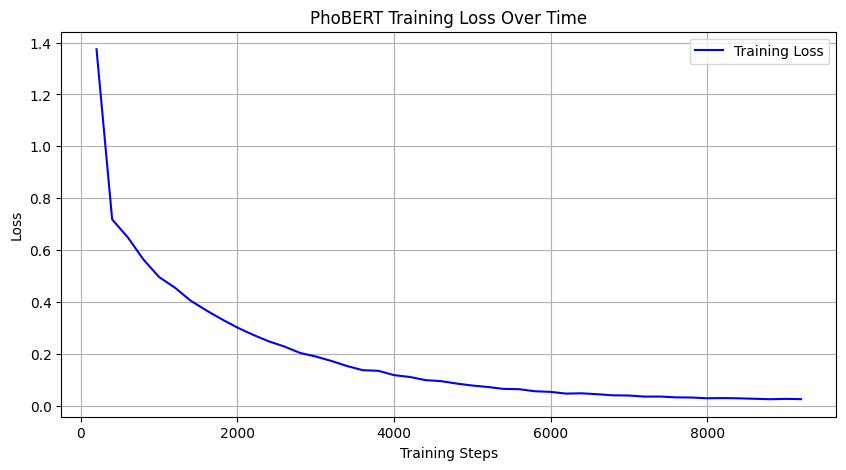

In [36]:
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)
df_loss = df[df['loss'].notna()]

# Plot the training loss over time
plt.figure(figsize=(10, 5))
plt.plot(df_loss['step'], df_loss['loss'], label="Training Loss", color="blue")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("PhoBERT Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [37]:
import os
import torch

# Define save path
model_save_path = "./phobert_multitask-V2"

# Ensure the save directory exists
os.makedirs(model_save_path, exist_ok=True)

# ✅ Force CPU mode while saving
torch.save(model.cpu().state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config (useful when loading later)
model.config.to_json_file(f"{model_save_path}/config.json")

# Confirm saving is successful
print(f"✅ Model and tokenizer saved to {model_save_path}")

✅ Model and tokenizer saved to ./phobert_multitask-V2


In [38]:
trainer.save_model("./phoBERT-MultiTask-V1")

In [39]:
from transformers import AutoModel, AutoTokenizer

model_id = "Savoxism/phoBERT-MultiTask-V1"  # Change this to your username/model_name

# Push model to Hugging Face Hub
trainer.push_to_hub(model_id)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Savoxism/phobert_multitask/commit/6d5a1b37e264bfb35f298d531f801edbfb36fbf9', commit_message='Savoxism/phoBERT-MultiTask-V1', commit_description='', oid='6d5a1b37e264bfb35f298d531f801edbfb36fbf9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Savoxism/phobert_multitask', endpoint='https://huggingface.co', repo_type='model', repo_id='Savoxism/phobert_multitask'), pr_revision=None, pr_num=None)

In [40]:
import torch
from transformers import AutoTokenizer, AutoModel

# Define model path
model_path = "./phobert_multitask-V2"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load fine-tuned model
model = PhoBERTMultiTaskModel(model_name="vinai/phobert-base", num_aspects=34)

# ✅ Force loading on CPU to avoid NCCL issues
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

<ipython-input-40-3247524bbe50>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location=device))


PhoBERTMultiTaskModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [41]:
import torch

def predict(text):
    """Tokenizes input text, runs inference, and returns predicted aspect presence & sentiment."""

    # ✅ Tokenize input text and move to the same device as the model
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # ✅ Move to correct device

    # Run inference
    with torch.no_grad():
        aspect_preds, sentiment_preds = model(**inputs)  # ✅ Model outputs two predictions

    # ✅ Convert logits to class predictions
    aspect_probs = torch.sigmoid(aspect_preds)  # Convert logits to probabilities (binary classification)
    aspect_predictions = (aspect_probs > 0.3).cpu().numpy().flatten().tolist()  # Convert to 0 or 1

    sentiment_labels = torch.argmax(sentiment_preds, dim=-1).cpu().numpy().flatten().tolist()  # Convert logits to class indices

    # ✅ Sentiment mapping
    sentiment_map = {0: "None", 1: "Positive", 2: "Negative", 3: "Neutral"}

    # ✅ Prepare output
    predictions = {}
    for aspect, aspect_present, sentiment in zip(label_keys, aspect_predictions, sentiment_labels):
        if aspect_present == 1:  # ✅ Only include aspects that are detected
            predictions[aspect] = sentiment_map[int(sentiment)]

    return predictions  # ✅ Returns dictionary of detected aspects & their sentiment

In [42]:
# text = input()
text = "Ga giường không sạch, nhân viên quên dọn phòng một ngày."
predictions = predict(text)
print(predictions)

{'FACILITIES#CLEANLINESS': 'None', 'FACILITIES#DESIGN&FEATURES': 'None', 'FACILITIES#MISCELLANEOUS': 'None', 'FACILITIES#QUALITY': 'None', 'FOOD&DRINKS#PRICES': 'None', 'FOOD&DRINKS#STYLE&OPTIONS': 'None', 'HOTEL#COMFORT': 'None', 'HOTEL#GENERAL': 'None', 'HOTEL#PRICES': 'None', 'LOCATION#GENERAL': 'None', 'ROOMS#COMFORT': 'None', 'ROOMS#MISCELLANEOUS': 'None', 'ROOMS#PRICES': 'None', 'ROOM_AMENITIES#CLEANLINESS': 'None', 'ROOM_AMENITIES#DESIGN&FEATURES': 'None', 'ROOM_AMENITIES#MISCELLANEOUS': 'None', 'ROOM_AMENITIES#QUALITY': 'None'}


# accuracy on test set

In [43]:
tokenized_dataset["test"]

Dataset({
    features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'attention_mask', 'aspect_labels', 'sentiment_labels'],
    num_rows: 600
})

In [44]:
test_dataloader = DataLoader(
    tokenized_dataset["test"], 
    batch_size=8, 
    collate_fn=collate_fn, 
    shuffle=True
)

In [45]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_aspect_preds, all_aspect_labels = [], []
all_sentiment_preds, all_sentiment_labels = [], []

# Loop through test dataset
with torch.no_grad():
    for batch in test_dataloader:  # Assume test_dataloader is defined
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        aspect_labels = batch["aspect_labels"].to(device)  # Shape: (batch_size, num_aspects, 2)
        sentiment_labels = batch["sentiment_labels"].to(device)  # Shape: (batch_size, num_aspects, 4)

        # Get model predictions
        aspect_logits, sentiment_logits = model(input_ids, attention_mask)

        # Convert logits to predictions
        aspect_preds = torch.argmax(aspect_logits, dim=-1)  # Shape: (batch_size, num_aspects)
        sentiment_preds = torch.argmax(sentiment_logits, dim=-1)  # Shape: (batch_size, num_aspects)

        # ✅ Convert one-hot encoded labels to class indices
        aspect_labels = aspect_labels.argmax(dim=-1)  # Shape: (batch_size, num_aspects)
        sentiment_labels = sentiment_labels.argmax(dim=-1)  # Shape: (batch_size, num_aspects)

        # Debugging: Print shapes after fixing
        print(f"Fixed aspect_preds shape: {aspect_preds.shape}, aspect_labels shape: {aspect_labels.shape}")

        # Flatten tensors correctly
        all_aspect_preds.extend(aspect_preds.cpu().numpy().reshape(-1))  
        all_aspect_labels.extend(aspect_labels.cpu().numpy().reshape(-1))

        all_sentiment_preds.extend(sentiment_preds.cpu().numpy().reshape(-1))
        all_sentiment_labels.extend(sentiment_labels.cpu().numpy().reshape(-1))

# ✅ Compute Accuracy
assert len(all_aspect_preds) == len(all_aspect_labels), f"Shape mismatch: {len(all_aspect_preds)} preds vs {len(all_aspect_labels)} labels"
assert len(all_sentiment_preds) == len(all_sentiment_labels), f"Shape mismatch: {len(all_sentiment_preds)} preds vs {len(all_sentiment_labels)} labels"

aspect_accuracy = accuracy_score(all_aspect_labels, all_aspect_preds)
sentiment_accuracy = accuracy_score(all_sentiment_labels, all_sentiment_preds)

print(f"✅ Aspect Detection Accuracy: {aspect_accuracy:.4f}")
print(f"✅ Sentiment Classification Accuracy: {sentiment_accuracy:.4f}")

# ✅ Compute F1 Score for better evaluation
aspect_f1 = f1_score(all_aspect_labels, all_aspect_preds, average="macro")
sentiment_f1 = f1_score(all_sentiment_labels, all_sentiment_preds, average="macro")

print(f"✅ Aspect Detection F1 Score: {aspect_f1:.4f}")
print(f"✅ Sentiment Classification F1 Score: {sentiment_f1:.4f}")


Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.Size([8, 34]), aspect_labels shape: torch.Size([8, 34])
Fixed aspect_preds shape: torch.

In [46]:
import numpy as np

# Convert lists to NumPy arrays for efficient calculations
all_sentiment_preds = np.array(all_sentiment_preds)
all_sentiment_labels = np.array(all_sentiment_labels)

# Define sentiment classes (adjust based on your dataset's encoding)
SENTIMENT_CLASSES = ["None", "Positive", "Negative", "Neutral"]

# Count total occurrences of each sentiment class in ground truth
total_counts = {sentiment: np.sum(all_sentiment_labels == i) for i, sentiment in enumerate(SENTIMENT_CLASSES)}

# Count correct predictions for each sentiment class
correct_counts = {sentiment: np.sum((all_sentiment_labels == i) & (all_sentiment_preds == i)) for i, sentiment in enumerate(SENTIMENT_CLASSES)}

# Print results
print("\n✅ Sentiment Classification Breakdown:")
for sentiment in SENTIMENT_CLASSES:
    total = total_counts[sentiment]
    correct = correct_counts[sentiment]
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"  {sentiment}: {correct}/{total} correct ({accuracy:.2f}%)")



✅ Sentiment Classification Breakdown:
  None: 17498/17816 correct (98.22%)
  Positive: 1471/1806 correct (81.45%)
  Negative: 400/645 correct (62.02%)
  Neutral: 18/133 correct (13.53%)


In [47]:
import numpy as np

# Convert lists to NumPy arrays for indexing
all_sentiment_preds = np.array(all_sentiment_preds)
all_sentiment_labels = np.array(all_sentiment_labels)

# Find indices where true sentiment = "Negative" (class index 2) and prediction is also 2
negative_correct_indices = np.where((all_sentiment_labels == 2) & (all_sentiment_preds == 2))[0]

if len(negative_correct_indices) > 0:
    # Select a random correctly classified negative sentiment sample
    selected_index = np.random.choice(negative_correct_indices)
    
    # Retrieve corresponding input from test_dataloader
    batch_idx = selected_index // test_dataloader.batch_size  # Find batch index
    sample_idx = selected_index % test_dataloader.batch_size  # Find sample within batch
    
    # Load the corresponding batch
    batch = next(iter(test_dataloader))  # Get one batch (assuming batch order is consistent)
    
    # Extract input IDs and decode the text
    input_ids = batch["input_ids"][sample_idx].tolist()
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

    print("✅ Example where model correctly classified 'Negative':")
    print(f"Text: {decoded_text}")
    print(f"True Sentiment: Negative")
    print(f"Predicted Sentiment: Negative")
else:
    print("❌ No correctly classified 'Negative' samples found.")


✅ Example where model correctly classified 'Negative':
Text: rất thích bể sục của khách_sạn phòng tôi ở là hạng phòng deluxe có tiện_ích xông_hơi trong phòng tắm rất hài_lòng nên có thêm nhiều loại nước uống hoa_quả hơn cho buổi buffet sáng
True Sentiment: Negative
Predicted Sentiment: Negative


# Save and Publish Model

In [48]:
!zip -r phobert_multitask-V2.zip /kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2

  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/ (stored 0%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/added_tokens.json (stored 0%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/config.json (deflated 49%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/pytorch_model.bin (deflated 16%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/vocab.txt (deflated 55%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/tokenizer_config.json (deflated 77%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/special_tokens_map.json (deflated 57%)
  adding: kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2/bpe.codes (deflated 59%)


In [49]:
# import os

# file_path = "/kaggle/working/ABSA-Vietnamese-main/phobert_multitask-V2"

# # Check if file exists
# if os.path.exists(file_path):
#     print("✅ File exists, generating download link...")
# else:
#     print("🚨 File not found! Check the file path.")


In [50]:
# from IPython.display import FileLink

# # Provide a download link for the ZIP file
# FileLink("/kaggle/working/ABSA-Vietnamese-main/phobert-v2-multitask.zip")